In [22]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

from scipy.stats import pearsonr

import trompy as tp

colors_PVH = "#219C90"
colors_VMH  = "#90219c"

cmap = "RdBu_r"


In [2]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH = pickle.load(handle)

with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH = pickle.load(handle)   

In [3]:
PVH_mouse_to_be_analyzed = "HL210"
VMH_mouse_to_be_analyzed = "HL303" #310

In [6]:
def get_snips_and_aucs(data, mouse):
    snips_start = []
    snips_end = []
    snips_full = []
    run_lengths = []

    kwargs = {"bins": 150, "trial_length": 15, "baseline_length": 5}
    pre = 5
    post = 10
    mineventlength_snips = 10
    mineventlength_aucs = 8
    binlength = 0.1

    for key, val in data.items():
        if val["mouse_ID"] == mouse:
            if len(val["licks"]) < 10:
                continue

            lickdata = tp.lickCalc(val["licks"], minrunlength=3)

            # Snips part
            snips_start.append(tp.snipper(val["corrected"], lickdata["rStart"], val["fs"], **kwargs)[0])
            snips_end.append(tp.snipper(val["corrected"], lickdata["rEnd"], val["fs"], **kwargs)[0])

            snipper_snips = tp.Snipper(val["corrected"],
                                       lickdata["rStart"],
                                       end=lickdata["rEnd"],
                                       fs=val["fs"],
                                       pre=pre,
                                       post=post,
                                       binlength=binlength,
                                       zscore=True
                                       )
            snipper_snips.truncate_to_same_length(cols_to_add=10, mineventlength=mineventlength_snips)
            snipper_snips.find_potential_artifacts(threshold=8, method="sum")
            snips_full.append(snipper_snips.snips)

            # AUCs part
            snipper_aucs = tp.Snipper(val["corrected"],
                                      lickdata["rStart"],
                                      end=lickdata["rEnd"],
                                      fs=val["fs"],
                                      pre=pre,
                                      post=post,
                                      binlength=binlength,
                                      zscore=True
                                      )
            snipper_aucs.truncate_to_same_length(cols_to_add=10, mineventlength=mineventlength_aucs, eventbalance=[6, 2])
            snipper_aucs.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
            plt.plot(snipper_aucs.snips.T, color="black", alpha=0.1)

            # Run lengths for AUCs
            run_lengths_temp = (np.array(lickdata["rEnd"]) - np.array(lickdata["rStart"]))
            run_lengths.append(run_lengths_temp[run_lengths_temp > mineventlength_aucs])

    # Concatenating snips data
    try:
        snips_start = np.vstack(snips_start)
        snips_end = np.vstack(snips_end)
        snips_full = np.vstack(snips_full)
        print("adding this mouse")
    except ValueError:
        print("no snips to concatenate")

    # Flatten run lengths
    run_lengths = tp.flatten_list(run_lengths)

    # AUC calculations
    if len(snips_full) > 0:
        auc_early_licking = np.trapz(snips_full[:, 50:110], axis=1) / 60  # 6 seconds
        auc_late_licking = np.trapz(snips_full[:, 120:140], axis=1) / 20  # 2 seconds
        auc_early_post_licking = np.trapz(snips_full[:, 140:190], axis=1) / 50  # 5 seconds
        auc_late_post_licking = np.trapz(snips_full[:, 190:240], axis=1) / 50  # 5 seconds

        auc_df = pd.DataFrame([run_lengths,
                               auc_early_licking,
                               auc_late_licking,
                               auc_early_post_licking,
                               auc_late_post_licking],
                              index=["run_lengths", "auc_early_licking", "auc_late_licking", "auc_early_post_licking", "auc_late_post_licking"]).T
    else:
        auc_df = pd.DataFrame(columns=["run_lengths", "auc_early_licking", "auc_late_licking", "auc_early_post_licking", "auc_late_post_licking"])
        print("No AUC data to compute")

    return snips_start, snips_end, snips_full, auc_df


<class 'numpy.ndarray'>
No event balance given. Using default 50-50 split.
Found 8 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
No event balance given. Using default 50-50 split.
Found 3 potential artifacts.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
No event balance given. Using default 50-50 split.
Found 0 potential artifacts.
No artifacts found.
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
adding this mouse


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

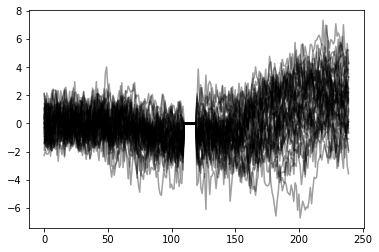

In [7]:
PVH_snips_start, PVH_snips_end, PVH_snips_full, PVH_AUC = get_snips_and_aucs(PVH, PVH_mouse_to_be_analyzed)

In [14]:
# Define thresholds based on standard deviation
early_threshold = np.std(PVH_AUC['auc_early_licking']) * 3
early_qs = "auc_early_licking < @early_threshold and auc_early_licking > -@early_threshold"

late_threshold = np.std(PVH_AUC['auc_late_licking']) * 3
late_qs = "auc_late_licking < @late_threshold and auc_late_licking > -@late_threshold"

early_post_threshold = np.std(PVH_AUC['auc_early_post_licking']) * 3
early_post_qs = "auc_early_post_licking < @early_post_threshold and auc_early_post_licking > -@early_post_threshold"

late_post_threshold = np.std(PVH_AUC['auc_late_post_licking']) * 3
late_post_qs = "auc_late_post_licking < @late_post_threshold and auc_late_post_licking > -@late_post_threshold"

# Combine query strings
query_string = f"{early_qs} and {late_qs} and {early_post_qs} and {late_post_qs}"
filtered_pvh = PVH_AUC.query(query_string)

Early AUC vs. Run Length: r=-0.038, p=0.855
Late AUC vs. Run Length: r=0.256, p=0.207
Early Post AUC vs. Run Length: r=0.107, p=0.604
Late Post AUC vs. Run Length: r=0.073, p=0.724


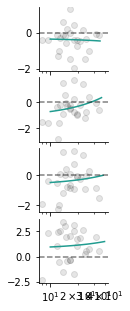

In [23]:
def plot_scatter_and_line_of_best_fit(x, y, ax, color, alpha=0.1):
    ax.scatter(x, y, color="black", alpha=alpha)
    
    slope, intercept = np.polyfit(x, y, 1)
    xrange = np.linspace(10, ax.get_xlim()[1], 100)
    line = slope * xrange + intercept
    
    ax.plot(xrange, line, color=color) 

    return ax

f, ax = plt.subplots(nrows=4, figsize=(1,4),
                     sharex=True,
                     gridspec_kw={"hspace":0.1, "wspace":0.1,
                                  "left": 0.02,
                                  "right": 0.98,
                                  "top": 0.98,
                                  "bottom": 0.02})

plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_early_licking,
                                  ax[0],
                                  colors_PVH,
)

plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_late_licking,
                                  ax[1],
                                  colors_PVH
)

plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_early_post_licking,
                                  ax[2],
                                  colors_PVH
)

plot_scatter_and_line_of_best_fit(filtered_pvh.run_lengths,
                                  filtered_pvh.auc_late_post_licking,
                                  ax[3],
                                  colors_PVH
)

for axis in ax:
    axis.axhline(0, linestyle="--", color="black", alpha=0.5)
    axis.set_xscale("log")
    #axis.set_ylim(-8, 8)
    #axis.set_yticklabels([])
    #axis.set_xlim(4, 300)
    #axis.set_xticks([10, 100, 200, 300])
    #axis.set_xticklabels([])
    
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)

#f.savefig(FIGSFOLDER / "PVH_licking_correlations.pdf")


### STATISTICS FOR PVH

# Compute Pearson correlation coefficients and p-values
corr_early, p_value_early = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_early_licking)
corr_late, p_value_late = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_late_licking)
corr_early_post, p_value_early_post = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_early_post_licking)
corr_late_post, p_value_late_post = pearsonr(filtered_pvh.run_lengths, filtered_pvh.auc_late_post_licking)

print(f"Early AUC vs. Run Length: r={corr_early:.3f}, p={p_value_early:.3f}")
print(f"Late AUC vs. Run Length: r={corr_late:.3f}, p={p_value_late:.3f}")
print(f"Early Post AUC vs. Run Length: r={corr_early_post:.3f}, p={p_value_early_post:.3f}")
print(f"Late Post AUC vs. Run Length: r={corr_late_post:.3f}, p={p_value_late_post:.3f}")